## Effect of detrending on the anomalies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

from itertools import product
import xarray as xr


In [3]:
def detrend_series(y,m,b):
    # Return detrended series
    return y - (m*x )


def compute_anomalies(data,ds_baseline):

    gb = ds_baseline.groupby('time.dayofyear')
    clim = gb.mean(dim='time')
    std_clim = gb.std(dim='time')

    # reindex to full time series
    clim_time = clim.sel(dayofyear=data.time.dt.dayofyear)
    std_clim_time = std_clim.sel(dayofyear=data.time.dt.dayofyear)
    
    anomalies   = ((data - clim_time)/std_clim_time)

    return anomalies, clim_time, std_clim_time

## 1) Here we generate the detrended anomalies
1) Load original temperature data
2) Detrending sui singoli anni
3) Compute anomalies rispetto alla baseline originale 

In [10]:

VARIABLE        = 't2m'  
FILENAME_INPUT  = f"../data/t2m/t2m_1970_2022_5grid.nc"

# Load original data
data_orig        =  xr.open_dataarray(FILENAME_INPUT, engine='netcdf4') 


nlats = data_orig['lat'].size
nlons = data_orig['lon'].size
year  = 1985

# Define Baseline
ds_baseline = data_orig.where( (data_orig['time.year'] >= 1970) & (data_orig['time.year'] <= 1989), drop=True)


# Compute anomalies from original data (not detrended)
anomalies, clim_time, std_clim_time = compute_anomalies(data_orig,ds_baseline)


## Detrend baseline
x = np.array(list(range(len(ds_baseline['time']))),dtype=float)
for i,j in product(range(nlats),range(nlons)):
    # print(i,j)
    m, b = np.polyfit(x, ds_baseline[:,i,j], 1)
    ds_baseline[:,i,j] = detrend_series(ds_baseline[:,i,j], m,b)



In [ ]:
# year = 1970
# data_detrended = data_orig.where( (data_orig['time.year'] == year),drop=True)
# def detrend_series(y,m,b,t):
#     # Return detrended series
#     return y - (m*t) 
# i = 14
# j = 33
# t = np.array(list(range(len(data_detrended['time']))),dtype=float)
# x = data_orig[:,i,j]
# x = x.where( (x['time.year'] == year),drop=True)
# m, b = np.polyfit(t, data_detrended[:,i,j], 1)
# y = detrend_series(x,m,b,t)

# plt.plot(x,label='original')
# plt.plot(y,label='detrended')
# plt.legend()

In [11]:
# Select a specific year from original data
data_detrended = data_orig.copy()
data_detrended = data_detrended.where( (data_detrended['time.year'] == year),drop=True)

mlist = np.empty(nlats*nlons,dtype=float)
blist = np.empty(nlats*nlons,dtype=float)
x = np.array(list(range(len(data_detrended['time']))),dtype=float)

# Detrend data for the selected year
count = 0
for i,j in product(range(nlats),range(nlons)):
    # print(i,j)
    m, b = np.polyfit(x, data_detrended[:,i,j], 1)

    data_detrended[:,i,j] = detrend_series(data_detrended[:,i,j], m,b)
    # m, b = np.polyfit(x, data_detrended[:,i,j], 1)
    mlist[count] = m
    blist[count] = b
    count += 1


# Compute anomalies for detrended data
anomalies_detrended, clim_time, std_clim_time = compute_anomalies(data_detrended,ds_baseline)

In [ ]:
i,j, t = 3,4, np.arange(0,365)
data_orig1 = data_orig.where( (data_orig['time.year'] == 2010),drop=True)
t = np.array(list(range(len(data_orig1['time']))),dtype=float)
m, b = np.polyfit(t, data_orig1[:,i,j], 1)
print(m)
# plt.plot(data_orig[t,i,j])
# plt.plot(data_detrended[t,i,j])

## Compare the two versions

Text(0.5, 1.0, 'Year 1985')

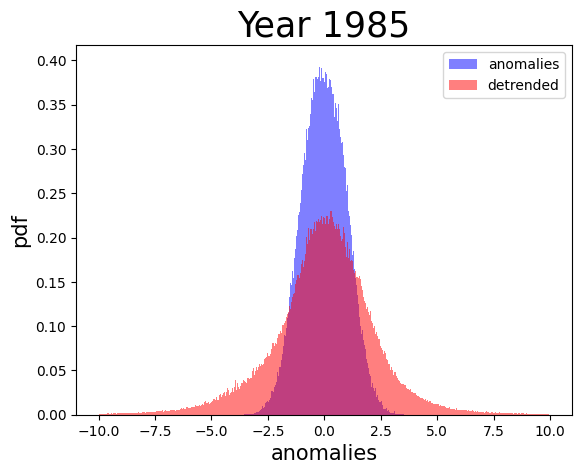

In [12]:
# Select year for anomalies
anomalies = anomalies.where( (anomalies['time.year'] == year),drop=True)
# anomalies_detrended = anomalies_detrended.where( (data_orig['time.year'] == year),drop=True)

time = np.array(range(len(anomalies)),dtype=float)

# NOTE: results are more spread out probably because we don't detrend the baseline in the same way

bins = np.arange(-10,10,0.03)
plt.hist(anomalies.stack(stacked=["time","lat","lon"]),bins=bins,color='b',density=True,alpha=0.5,label='anomalies');
plt.hist(anomalies_detrended.stack(stacked=["time","lat","lon"]),bins=bins,color='r',density=True,alpha=0.5,label='detrended');
plt.legend()
plt.ylabel('pdf',fontsize=15)
plt.xlabel('anomalies',fontsize=15)
plt.title(f'Year {year}',fontsize=25)

In [ ]:
i = 3
j = 45
x = data_orig[0:365,i,j]
y = data_detrended[:,i,j]
plt.plot(x)
plt.plot(y)

In [ ]:
m,b= np.polyfit(t,y,1)
print(m)
z = y-m*t
m1,b1 = np.polyfit(t,z,1)
print(m1)

# 2) Here we detrend all the series first

In [ ]:
VARIABLE        = 't2m'  
FILENAME_INPUT  = f"../data/t2m/t2m_1970_2022_5grid.nc"

# Load original data
data_orig        =  xr.open_dataarray(FILENAME_INPUT, engine='netcdf4') 


nlats = data_orig['lat'].size
nlons = data_orig['lon'].size
year  = 1985

# Define Baseline
ds_baseline = data_orig.where( (data_orig['time.year'] >= 1970) & (data_orig['time.year'] <= 1989), drop=True)



## Detrend baseline
x = np.array(list(range(len(ds_baseline['time']))),dtype=float)
for i,j in product(range(nlats),range(nlons)):
    # print(i,j)
    m, b = np.polyfit(x, ds_baseline[:,i,j], 1)
    ds_baseline[:,i,j] = detrend_series(ds_baseline[:,i,j], m,b)


# Compute anomalies from original data (not detrended)
anomalies, clim_time, std_clim_time = compute_anomalies(data_orig,ds_baseline)

In [ ]:
# Here we detrend all the series
data_detrended = data_orig.copy()

mlist = np.empty(nlats*nlons,dtype=float)
blist = np.empty(nlats*nlons,dtype=float)
x = np.array(list(range(len(data_detrended['time']))),dtype=float)

# Detrend data for the selected year
count = 0
for i,j in product(range(nlats),range(nlons)):
    # print(i,j)
    m, b = np.polyfit(x, data_detrended[:,i,j], 1)

    data_detrended[:,i,j] = detrend_series(data_detrended[:,i,j], m,b)
    # m, b = np.polyfit(x, data_detrended[:,i,j], 1)
    mlist[count] = m
    blist[count] = b
    count += 1


# Compute anomalies for detrended data
anomalies_detrended, clim_time, std_clim_time = compute_anomalies(data_detrended,ds_baseline)

In [ ]:
# Select year for anomalies
# anomalies = anomalies.where( (anomalies['time.year'] == year),drop=True)
# anomalies_detrended = anomalies_detrended.where( (data_orig['time.year'] == year),drop=True)
year = 2000
time = np.array(range(len(anomalies)),dtype=float)


bins = np.arange(-10,10,0.03)
an = anomalies.where( (anomalies['time.year'] == year),drop=True)
an_det = anomalies_detrended.where( (anomalies_detrended['time.year'] == year),drop=True)
plt.hist(an.stack(stacked=["time","lat","lon"]),bins=bins,color='b',density=True,alpha=0.5,label='anomalies');
plt.hist(an_det.stack(stacked=["time","lat","lon"]),bins=bins,color='r',density=True,alpha=0.5,label='anom. detrended');
plt.legend()
plt.ylabel('pdf',fontsize=15)
plt.xlabel('anomalies',fontsize=15)
# plt.title(f'Global detrending',fontsize=25)
plt.title(f'Year {year}',fontsize=25)

plt.axvline(x=an.mean().data,color='k',linestyle='--')
plt.axvline(x=an_det.mean().data,color='k',linestyle='--')
# plt.text(5.0,0.06,f"mean anom {anomalies.mean().data:.2f}")
# plt.text(5.0,0.10,f"mean anom detrend {anomalies_detrended.mean().data:.2f}")


In [ ]:
a.data